In [1]:
%load_ext autoreload
%autoreload 2
from experiment.experiment import Experiment
from models.tensorflow.monde import Monde
from conf import conf
from models.tensorflow.conf import tf_conf
from experiment.hyper_param_opt import GridSearch
from models.tensorflow.tf_simple_train_eval import TfSimpleTrainEvalModelFactory
from skopt.space import Categorical
from models.tensorflow.utils import get_eval_inputs,get_inputs
from data.data_utils import DataLoader
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.palettes import Category10_5 as colors
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
import pandas as pd
from functools import reduce
from experiment.experiment import InMemoryCollector
from copy import copy
from sklearn.metrics import roc_curve,auc,precision_recall_curve,average_precision_score
from sklearn.ensemble import RandomForestClassifier
import os
from sklearn.utils.fixes import signature

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
exp = Experiment('classification/fx_3')
conf.num_workers = 1
conf.visible_device_list = [0]
exp.load(model_name="NNClassifier")

In [2]:
exp.data_loader.figure_train();

In [3]:
result_test = exp.predict_best_model("test_dict", InMemoryCollector())

In [6]:
fpr, tpr, thresholds = roc_curve(exp.data_loader.additional_test_data['labels'], result_test["probs"])
roc_auc = auc(fpr, tpr)

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic, Area=0.95')

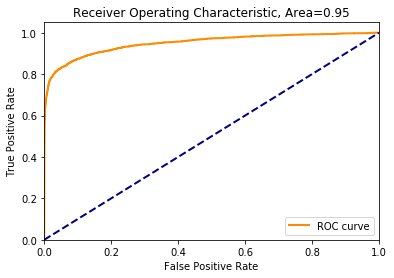

In [7]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic, Area={0:0.2f}'.format(roc_auc))
plt.legend(loc="lower right")
# plt.show();
plt.savefig('figures/roc_nn.png',dpi=1200)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

(0.0, 1.05)

(0.0, 1.0)

Text(0.5, 1.0, 'Precision-Recall curve: AP=0.87')

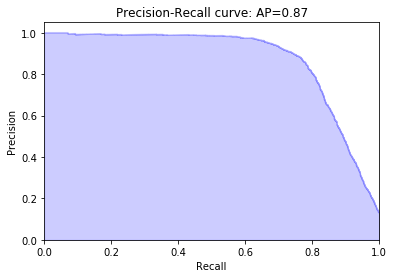

In [8]:
precision, recall, _ = precision_recall_curve(exp.data_loader.additional_test_data['labels'], result_test["probs"])
average_precision = average_precision_score(exp.data_loader.additional_test_data['labels'], result_test["probs"])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
# plt.show();
plt.savefig('figures/pr_nn.png',dpi=1200)

In [4]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(exp.data_loader.train_x, exp.data_loader.additional_train_data['labels'])

In [10]:
tree_predictions_test = clf.predict_proba(exp.data_loader.test_x)
tree_predictions_test = tree_predictions_test[:,1]

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic, Area=0.93')

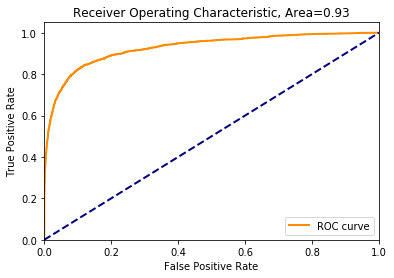

In [11]:
fpr, tpr, thresholds = roc_curve(exp.data_loader.additional_test_data['labels'], tree_predictions_test)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic, Area={0:0.2f}'.format(roc_auc))
plt.legend(loc="lower right")
# plt.show();
plt.savefig('/figures/roc_rf.png',dpi=1200)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

(0.0, 1.05)

(0.0, 1.0)

Text(0.5, 1.0, 'Precision-Recall curve, Area=0.78')

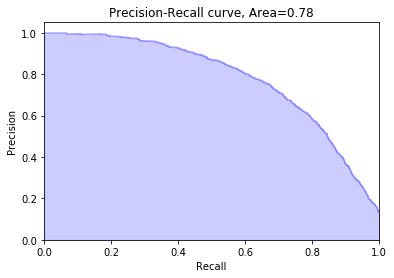

In [12]:
precision, recall, _ = precision_recall_curve(exp.data_loader.additional_test_data['labels'], tree_predictions_test)
average_precision = average_precision_score(exp.data_loader.additional_test_data['labels'], tree_predictions_test)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve, Area={0:0.2f}'.format(
          average_precision))
# plt.show();
plt.savefig('figures/pr_rf.png',dpi=1200)

In [5]:
# XGBoost on Otto dataset, tune subsample
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
model = XGBClassifier()
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(subsample=subsample)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=2, cv=kfold)
grid_result = grid_search.fit(exp.data_loader.train_x,  exp.data_loader.additional_train_data['labels'])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<ErrorbarContainer object of 3 artists>

Text(0.5, 1.0, 'XGBoost subsample vs Log Loss')

Text(0.5, 0, 'subsample')

Text(0, 0.5, 'Log Loss')

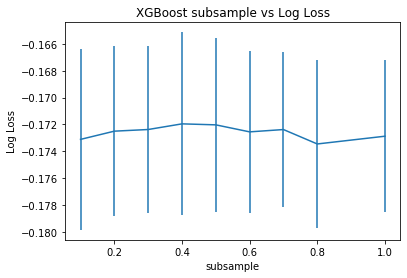

In [14]:
pyplot.errorbar(subsample, means, yerr=stds)
pyplot.title("XGBoost subsample vs Log Loss")
pyplot.xlabel('subsample')
pyplot.ylabel('Log Loss')
pyplot.savefig('subsample.png')

In [15]:
xgb_predictions_test = grid_search.predict_proba(exp.data_loader.test_x)
xgb_predictions_test = xgb_predictions_test[:,1]

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic, Area=0.94')

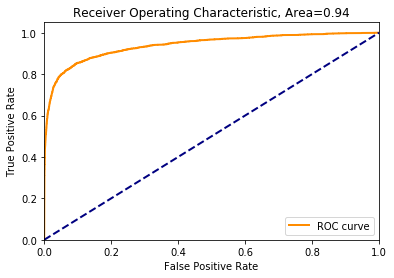

In [ ]:
fpr, tpr, thresholds = roc_curve(exp.data_loader.additional_test_data['labels'], xgb_predictions_test)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic, Area={0:0.2f}'.format(roc_auc))
plt.legend(loc="lower right")
# plt.show();
plt.savefig('figures/roc_xgb.png',dpi=1200)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

(0.0, 1.05)

(0.0, 1.0)

Text(0.5, 1.0, 'Precision-Recall curve, Area=0.83')

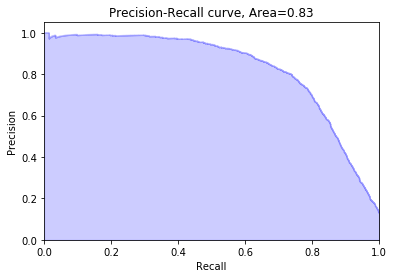

In [ ]:
precision, recall, _ = precision_recall_curve(exp.data_loader.additional_test_data['labels'], xgb_predictions_test)
average_precision = average_precision_score(exp.data_loader.additional_test_data['labels'], xgb_predictions_test)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve, Area={0:0.2f}'.format(
          average_precision))
# plt.show();
plt.savefig('figures/pr_xgb.png',dpi=1200)

In [ ]:
# # XGBoost on Otto dataset, tune colsample_bytree
# from pandas import read_csv
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold
# import matplotlib
# matplotlib.use('Agg')
# from matplotlib import pyplot
# # load data
# model = XGBClassifier()
# colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
# param_grid = dict(colsample_bytree=colsample_bytree)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(exp.data_loader.train_x, train_labels)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# # plot
# pyplot.errorbar(colsample_bytree, means, yerr=stds)
# pyplot.title("XGBoost colsample_bytree vs Log Loss")
# pyplot.xlabel('colsample_bytree')
# pyplot.ylabel('Log Loss')
# pyplot.savefig('colsample_bytree.png')

In [ ]:
# xgb_predictions_test = grid_search.predict_proba(data_loader.test_x)
# xgb_predictions_test = xgb_predictions_test[:,1]

In [ ]:
# fpr, tpr, thresholds = roc_curve(true_label_test, xgb_predictions_test)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show();

In [ ]:
# model = XGBClassifier()
# colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
# param_grid = dict(colsample_bylevel=colsample_bylevel)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(exp.data_loader.train_x, train_labels)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# # plot
# pyplot.errorbar(colsample_bylevel, means, yerr=stds)
# pyplot.title("XGBoost colsample_bylevel vs Log Loss")
# pyplot.xlabel('colsample_bylevel')
# pyplot.ylabel('Log Loss')
# pyplot.savefig('colsample_bylevel.png')

In [ ]:
# xgb_predictions_test = grid_search.predict_proba(data_loader.test_x)
# xgb_predictions_test = xgb_predictions_test[:,1]

In [ ]:
# fpr, tpr, thresholds = roc_curve(true_label_test, xgb_predictions_test)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show();